<a name="cell-TOC"></a>

### 11. More Sampling / Bayesian Inference

0. [[Review] Integral Estimation](#cell-INTest)
  0. [Variance Reduction](#cell-MCint-importanceSampling-VarRed2)
    - [Antithetic Sampling](#cell-MCint-importanceSampling-antithetic)
    - [Control Variates](#cell-MCint-importanceSampling-variate)

  1. [Integral Approximation](#cell-Approximation)
    - [Newton-Côtes Quadrature](#cell-NewtonCotes)
    - [Riemann Integrals](#cell-Riemann)
    - [[OMITTED] Trapezoidal Quadrature](#cell-Trapezoidal)
    - [[OMITTED] Simpson's Rule](#cell-Simpson)
    - [[OMITTED]  Romberg Acceleration](#cell-Romberg)
    - [[OMITTED] Gaussian Quadrature](#cell-GaussianQuadrature)

1. [High Dimensional Integration](#cell-MCint-sampling)
  0. [Markov Chain Monte Carlo (MCMC)](#cell-MCint-sampling-MCMC)
  1. [Slice Sampling](#cell-MCint-SliceSampling)
  2. [Gibbs Sampling](#cell-MCint-sampling-MCMC-gibbs)
  3. [Convergence / Markov Chain Mixing](#cell-MCint-sampling-MCMC-mixing)
  4. [Metropolis-Hastings](#cell-MCint-sampling-MCMC-MH)
    - [[OMITTED] Transition Kernels](#cell-MCint-sampling-MCMC-transitionK)
    - [[OMITTED] Detailed Balance](#cell-MCint-sampling-MCMC-db)

2. [Hamiltonian Monte Carlo (HMC)](#cell-MCint-sampling-MCMC-HMC)
  0. [Hamiltonian Dynamics and Metropolis-Hastings](#cell-MCint-sampling-MCMC-HMC2)
  1. [Marginal Samples from Joint Distributions](#cell-MCint-sampling-MCMC-HMC3)
  2. [Diagnostics](#cell-MCint-sampling-MCMC-diagnostics)

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pymc as pm

<a name="cell-INTest"></a>

# 11.0 [Review] Integral Estimation ([Return to TOC](#cell-TOC))

---

If we can write

$$ \int f(x) dx \; = \int g(x)p(x) dx \quad \text{ then } \quad \int f(x) dx = E_{X\sim p_X(x)}[g(x)]$$

so  

$$\hat \theta \; \text{ estimating }\; E_X[g(x)] \quad \text{ also estimates } \quad \int f(x) dx$$

If the ***central limit theorem*** for $\hat \theta$ estimating $E_X[g(x)]$ applies, then the ***standard error*** of the estimator defines how accurate the ***integral estimation*** is.

<a name="cell-MCint-importanceSampling-VarRed2"></a>

## 11.0.0 Variance Reduction ([Return to TOC](#cell-TOC))
----

For
$$\mu = \int \frac{f(x)}{q(x)}q(x) dx = \text{E}_{X\sim q_X}[g(x)]$$

if $x_i \sim q_X$

$$ \widehat{\text{Var}}_{X\sim q(x)}\left[g(x_i)\right] = \frac{1}{n} \sum_{i=1}^n \left( \frac{f(x_i)}{q(x_i)} - \text{E}_{X\sim q_X}\left[ \frac{f(x_i)}{q(x_i)} \right] \right)^2 = 
\frac{1}{n} \sum_{i=1}^n  \left( \frac{f(x_i)}{q(x_i)} - \mu \right)^2$$

is $0$ if $q(x_i) = f(x_i)/\mu$.  This suggests that integral estimation is optimal when sampling from $q_X(x)$ that is proportional to $f(x)$. 

> This was demonstrated in the week 1 notes, which biased samples exactly in this manner towards the most relevant (non-zero) regions of the integration. 

Sometimes the variance can be further reduced by identifying and leveraging available correlations present in collections of estimators.

<a name="cell-MCint-importanceSampling-antithetic"></a>


### Antithetic Sampling ([Return to TOC](#cell-TOC))

---

Suppose $\bar x_1$ and $\bar x_2$ are both unbiased estimators of the same target, and have correlation $\rho = \frac{Cov(\bar x_1+\bar x_2)}{\sigma_{\bar x_1}\sigma_{\bar x_2}}$. If (for simplicity) $\sigma_{\bar x_1}^2=\sigma_{\bar x_2}^2=\frac{\sigma^2}{n}$, then

$$
\begin{align*}
Var\left(\frac{\bar x_1+\bar x_2}{2}\right) = {} & \frac{Var(\bar x_1)+Var(\bar x_2)}{4} + \frac{2Cov(\bar x_1+\bar x_2)}{4} \\
= {} & \frac{\sigma^2}{2n} + \frac{\frac{\sigma}{\sqrt{n}}\frac{\sigma}{\sqrt{n}}\rho}{2} = \frac{(1+\rho)\sigma^2}{2n}
\end{align*}$$

So if $\rho<0$ the averaged estimator could have substantially lower variance than either of the individuals estimators, and $\rho<0$ is not as hard to achieve as might initially be imagined, e.g., 
- $\rho_{\bar x_1,\bar x_2} < 0$ if $x_{2i} = -x_{1i}$ for $x_{1i}\sim N(\mu, \sigma^2)$
- $\rho_{\bar x_1,\bar x_2} < 0$ if $x_{2i} = 1-x_{1i}$ for $x_{1i}\sim U(0,1)$


> Even if $0\leq\rho\leq 1$, the demonstration above shows how averaging estimators is beneficial.  When $\rho=0$ the familiar ***law of large numbers*** appears, and when $\rho=1$ there is no benefit of averaging ***Bagging*** in ***random forests*** considers $0<\rho<1$ since for (tree-based) predictions $t_k, k=1,\cdots, K$ with (for simplicity) a common variance $\sigma^2_{t}$ and shared correlation $\rho = \frac{Cov(t_k,t_{k'})}{\sigma^2_{t}}$
> $$
\begin{align*}Var(\bar t) = {} & \frac{1}{K^2} \sum_{k=1}^K \sigma^2_t + \frac{2}{K^2} \sum_{k,k'} \sigma_t^2 \rho\\
= {} & \frac{\sigma^2}{K} + \frac{\frac{2}{2}(K^2-K)\sigma_t^2\rho}{K^2}
 = \rho \sigma^2 + \frac{(1-\rho)\sigma^2}{K}
\end{align*}$$
> showing that the uncorrelated contribution in the average estimator is reduced in a ***law of large numbers*** manner.


<!-- = \frac{\sigma^2}{K} + \sigma_t^2\rho - \frac{\sigma_t^2\rho}{K} -->

In [ ]:
# Here's an example using importance sampling, but notice
# that the antithetical sampling is a general strategy that 
# could be used in other contexts besides importance sampling
tilde_X = stats.uniform()
X = stats.beta(2,2)
n = 10000
tilde_x = tilde_X.rvs(size=n) 
x = X.rvs(size=n)
w = X.pdf(tilde_x)/tilde_X.pdf(tilde_x)

def region(x, a=.95,b=.99):
  return (x>a)&(x<b)

print("True Value ", X.cdf(.99)-X.cdf(.95))
print("Importance Sampling Estimate")
print("           ", (w*region(tilde_x)).mean())
# Antithetical Sampling
tilde_x_1 = w*region(tilde_x)
tilde_x_2 = w*region(1-tilde_x)
tilde_xs_ave = 0.5*(tilde_x_1.mean()+tilde_x_2.mean())
print("Importance+Antithetical Sampling  Estimate")
print("           ", tilde_xs_ave)

True Value  0.006951999999999958
Importance Sampling Estimate
            0.006099494115854056
Importance+Antithetical Sampling  Estimate
            0.006124347673340193


In [ ]:
print("Importance Sampling Variance")
print(np.var(w*region(tilde_x)))
print("Importance+Antithetical Sampling Variance")
# here's one way to estimate the variance of the Antithetical Sampling estimate
tilde_xs_var = 0.25*(np.var(tilde_x_1)/n + 
                     np.var(tilde_x_2)/n + 
                     (2/n**2)*np.cov(tilde_x_1, tilde_x_2)[0,1])
print(tilde_xs_var*n) # n factor to rescale to single sample

Importance Sampling Variance
0.001164002068148471
Importance+Antithetical Sampling Variance
0.0005741573403902581


<a name="cell-MCint-importanceSampling-variate"></a>

### Control Variates ([Return to TOC](#cell-TOC))

---

If correlation between estimators is known, regardless of the target of the estimators, the correlation may be exploited whenever the true value of auxiliary estimators is known.

For any estimator $\hat \theta$ of interest and any other correlated estimator $\hat \lambda$

- where the estimators need not even estimate the same target, e.g.,
  $$E[\hat \theta] = \theta  \not = \lambda = E[\hat \lambda]$$
- and where $\lambda$ and $Cov(\hat \theta, \hat \lambda)$ must be known so that

  1. since $Cov(\hat \theta, \hat \lambda)$ is known the relative value of $\hat \lambda$ to $\lambda$ is informative of the relative value of $\hat \theta$ to $\theta$
     - e.g., for $Cov(\hat \theta, \hat \lambda)>0$, then if $\hat \lambda > \lambda$ it is likely that $\hat \theta > \theta$ (and if $\hat \lambda < \lambda$ it is likely that $\hat \theta < \theta$)
     
  2. the estimator $\hat \theta + \underset{- \text{ when } \hat \lambda > \lambda}{\overset{+ \text{ when } \hat \lambda > \lambda}{\beta (\hat \lambda-\lambda)}}$ can be used to correct for expected under and over estimates in $\hat \theta$ based on observed under and over estimates of $\hat \lambda$ compared with $\lambda$.

Specifically, when the above requirements are met

$$
\begin{align*}
Var\left(\hat \theta + \beta (\hat \lambda-\lambda)\right) ={} & \overbrace{Var\left(\hat \theta \right) + \beta^2 Var (\hat \lambda) + 2 \beta Cov \left( (\hat \theta, \hat \lambda \right)}^{\frac{\partial}{\partial \beta} Var\left(\hat \theta + \beta (\hat \lambda-\lambda)\right) \,=\, 0 \; \Rightarrow \; 2\beta Var(\hat \lambda ) +2 Cov(\hat \theta, \hat \lambda) \,=\,0} 
= \; Var\left(\hat \theta \right) + \left(-\frac{Cov(\hat \theta, \hat \lambda)}{Var\left(\hat \lambda \right)}\right)^2 Var\left(\hat \lambda \right) - 2\frac{Cov(\hat \theta, \hat \lambda)}{Var\left(\hat \lambda \right)}Cov(\hat \theta, \hat \lambda) \\
= {} & \;  Var\left(\hat \theta \right) - \frac{\left(Cov(\hat \theta, \hat \lambda)\right)^2}{Var\left(\hat \lambda \right)} < Var\left(\hat \theta \right)
\end{align*}
$$

where the above quantities can be emprically estimated from the samples in hand, and this method can be extended to include as many auxiliary estimators as are available with $\hat \theta + \sum_{k=0}^K \beta (\hat \lambda_k-\lambda_k)$.

> In importance sampling, it is known that $E[W_i^*] = 1$, 
> so a control variate estimator can be constructed as 
> $$\overline{W^*Y} + \beta (\overline{W^*}-1)$$ 
> and while this will add bias of $\mathcal{O}(\frac{1}{n})$, the MSE of this estimator will eventually be better than that of $\overline{W^*Y}$ for sufficiently large $n$.

In [ ]:
# Here's the above example using importance sampling; however
# control variates are a general methodology 
# that can be used in contexts besides importance sampling

# E[W*] = 1 is known; thus a control variate estimator is
# \bar{w*y} + \beta (\bar{w*} - 1)

tilde_X = stats.uniform()
X = stats.beta(2,2)
n = 10000
tilde_x = tilde_X.rvs(size=n) 
x = X.rvs(size=n)
w = X.pdf(tilde_x)/tilde_X.pdf(tilde_x)

def region(x, a=.95,b=.99):
  return (x>a)&(x<b)

print("True Value ", X.cdf(.99)-X.cdf(.95))
print("Importance Sampling Estimate")
print("           ", (w*region(tilde_x)).mean())
# Control Variates
beta = -np.cov(w*region(tilde_x), w, ddof=1)[0,1]/np.var(w, ddof=1)
# an optimal beta can be found as shown on top of the equation above
print("Importance+Control Variate Sampling Estimate")
print("           ", (w*region(tilde_x)).mean() + (w.mean()-1)*beta)
print("Control Variate and beta values: ", (w.mean()-1), beta)

True Value  0.006951999999999958
Importance Sampling Estimate
            0.007025882636340844
Importance+Control Variate Sampling Estimate
            0.006800822638340491
Control Variate and beta values:  -0.008159653670700262 0.027582052754089263


In [ ]:
print("Importance Sampling Variance")
print(np.var(w*region(tilde_x)))
print("Importance+Control Variate Sampling Variance")
# here's one way to estimate the variance of the Control Variate Sampling estimate
tilde_cv_var = np.var(w*region(tilde_x), ddof=1) + \
               beta**2*np.var(1-w, ddof=1) + \
               2*beta*np.cov(w*region(tilde_x), w, ddof=1)[0,1]
# or by the inequality derived above 
           # = np.var(w*region(tilde_x), ddof=1) - \
           #   np.cov(w*region(tilde_x), w, ddof=1)[0,1]**2/np.var(w, ddof=1)
print(tilde_cv_var) # n factor to rescale to single sample

Importance Sampling Variance
0.0013156965999057719
Importance+Control Variate Sampling Variance
0.0011612568518402661


<a name="cell-Approximation"></a>

## 11.0.1 Integral Approximation ([Return to TOC](#cell-TOC))

---

The alternative to estimating integrals (or analytically deriving their solution) is to replace the integrand $f(x)$ with an approximation $g(x) \approx f(x)$. E.g., a sequence of piecewise function approximations $g_j(x)$, allows the integration to be approximated 

$$\int_{x_0}^{x_n}  \!\!\!\!\!\! f(x) dx = \sum_{j=0}^{n-1} \int_{x_j}^{x_{j+1}} \!\!\!\!\!\!\!\!\! f(x) dx \approx \sum_{j=0}^{n-1} \int_{x_j}^{x_{j+1}} \!\!\!\!\!\!\!\!\! g_j(x) dx$$

with a ***discrete approximation*** using a series of simpler integration problems with known solutions. 

<a name="cell-NewtonCotes"></a>

### Newton-Côtes Quadrature ([Return to TOC](#cell-TOC))

---

Replacing an integrand function with piecewise polynomial approximations within the intervals of an equally spaced ***discretization grid*** is known as ***Newton-Côtes quadrature***.
- The degree of the polynomial approximation within each interval determines the type of ***quadrature*** being used.
- The robustness of the approximation can be ascertained using ***adaptive quadrature*** which evaluates the sensitivity of the estimation to ***dicretization grid*** width and alignment configurations.

<a name="cell-Riemann"></a>

### Riemann Integrals ([Return to TOC](#cell-TOC))

---

***Riemann Integrals*** (i.e., the limit of ***Riemann sums***) approximate the function with an order $0$ (flat line) polynomial within each interval, so

$$ \int_{x_0}^{x_n}  \!\!\!\!\!\! f(x) dx = \sum_{j=0}^{n-1} \int_{x_j}^{x_{j+1}} \!\!\!\!\!\!\!\!\! f(x) dx \approx w \sum_{j=0}^{n-1}f(x_0 + jw) = \widehat R(n)$$

where $w=x_{j+1}-x_j$ and $$\lim_{n \rightarrow \infty}  \widehat R(n) = \int_{x_0}^{x_n} \!\! f(x) dx$$

and convergence (to the level of numerical precision availble) is monitored through a sequence of approximations where $n_{k+1} = 2n_k$ such that $w_{k+1} = w_k/2$ so half of the function evaluations at each step are already known from the previous step.  

> The above specifiction uses the approximation from the figure on the right, but the approximation from the figure on the left also converges appropriately, and a ***midpoint rule*** based approximation could also be considered.

|![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Riemann_Integration_and_Darboux_Upper_Sums.gif/300px-Riemann_Integration_and_Darboux_Upper_Sums.gif)|![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e3/Riemann_Integration_and_Darboux_Lower_Sums.gif/300px-Riemann_Integration_and_Darboux_Lower_Sums.gif)|
|-:|:-|
|Both of the images above are taken directly form|https://en.wikipedia.org/wiki/Integral#Interpretations|

<a name="cell-Trapezoidal"></a>

### [OMITTED] Trapezoidal Quadrature ([Return to TOC](#cell-TOC))

---

***Trapezoidal Quadrature*** approximates the function with a first order (straight line) polynomial within each interval, connecting the endpoints $f(x_{j})$ and $f(x_{j+1}$) of each interval, so

$$ 
\begin{align*}
\int_{x_0}^{x_n}  \!\!\!\!\!\! f(x) dx = \sum_{j=0}^{n-1} \int_{x_j}^{x_{j+1}} \!\!\!\!\!\!\!\!\! f(x) dx \approx {} & \sum_{j=0}^{n-1} \overbrace{\left(\frac{x_{j+1}-x_j}{2}\right)\left( f(x_{j+1}) + f(x_j) \right)}^{\text{trapezoidal rule}} \\
 = {} & \; \frac{wf(x_0)}{2} + w\sum_{j=1}^{n-1} f(x_0 + jw) + \frac{wf(x_n)}{2} = \widehat T(n)
\end{align*}$$

where $w=x_{j+1}-x_j$, the $\frac{1}{2}$ mostly goes away because all $f(x_j)$ except the endpoints are double counted, and

$$\lim_{n \rightarrow \infty}  \widehat T(n) = \int_{x_0}^{x_n} \!\! f(x) dx$$

and convergence (to the level of numerical precision availble) is monitored through a sequence of approximations where $n_{k+1} = 2n_k$ such that $w_{k+1} = w_k/2$ so half of the function evaluations at each step are already known from the previous step.  

|![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/Trapezium2.gif/440px-Trapezium2.gif)|
|-|
|The image above is taken from https://en.wikipedia.org/wiki/Trapezoidal_rule|

<a name="cell-Simpson"></a>

### [OMITTED] Simpson's Rule ([Return to TOC](#cell-TOC))

---

***Simpson's three-point $\frac{1}{3}$rd rule*** approximates the function with a second order (quadratic) polynomial within each interval which (exactly) interpolates the endpoints and midpoint $f(x_{j}), f(x_{j+1})$ and $f\left(\frac{x_{j+1}+x_{j}}{2}\right)$ of each interval, so (for even $n$)

$$\int_{x_0}^{x_n}  \!\!\!\!\!\! f(x) dx = \sum_{j=0}^{n-1} \int_{x_j}^{x_{j+1}} \!\!\!\!\!\!\!\!\! f(x) dx \approx \frac{h}{3} \sum_{i=1}^{n/2} \big( f(x_{2j-2}) + 4f(x_{2j-1}) + f(x_{2j}) \big) = \widehat S\left(\frac{n}{2}\right)$$

where $h = \frac{w}{2} = \frac{x_{j+1}-x_j}{2}$ and the approximation [can be shown](https://en.wikipedia.org/wiki/Simpson%27s_rule#Derivations) by either integration by parts or as the $\frac{2M+T}{3}$ weigted average of 
- the ***midpoint rule*** $\int_a^bf(x)dx \approx f(\frac{a+b}{2})(b-a) = M$ (similar to ***Riemann sums***)
- and the ***trapezoidal rule*** $\int_a^bf(x)dx \approx \frac{f(a)+f(b)}{2}(b-a) = T$ (as in ***trapezoidal quadrature***)

which analytically reduces approximation error.  However, whether or not a higher order polynomial approximation like ***Simpson's rule*** rather than a ***trapezoidal rule*** will improve the approximation for a given $n$ depends on the function being integrated itself and is by no means a certainty.

> A ***four-point $\frac{3}{8}$ths formula*** much like the ***three-point $\frac{1}{3}$rd rule*** 
is available for interpolating four points with a cubic function.
- Further higher order polynomial approximations are possible using the so-called ***method of undetermined coefficients***.

|<img src="https://upload.wikimedia.org/wikipedia/commons/f/fc/Simpson%27s_One-Third_Rule.gif"> | <img src='https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/Simpsonsrule2.gif/440px-Simpsonsrule2.gif'>|
|-:|:-|
|Both of the images above are taken directly form|https://en.wikipedia.org/wiki/Simpson's_rule |





<a name="cell-Romberg"></a>

### [OMITTED] Romberg Acceleration ([Return to TOC](#cell-TOC))

---

***Simpson's rule*** is derived by noticing that two approximations share a known analytical bias which can be cancelled through a weighted average of the two approximations, i.e., $\frac{2M+T}{3}$ in the case of ***Simpson's rule***.
In the context of integral approximation, a very clear factor which causes bias is the width of the ***discretization grid***.

Using the [Euler-Maclaurin formula](https://en.wikipedia.org/wiki/Euler%E2%80%93Maclaurin_formula), it can be shown that for ***trapezpoidal quadrature*** 
> based on a ***discretization*** with $n$ ***grid points*** and corresponding ***grid width*** $w$

there is a constant $c$ such that

$$\widehat T (n) = \int_{x_0}^{x_n} \!\!\!\! f(x) dx + cw^2 + O(n^{-4}) \quad \text{ and } \quad \widehat T (2n) = \int_{x_0}^{x_n} \!\!\!\! f(x) dx + \frac{c}{4}w^2 + O(n^{-4})$$

so ***Romberg acceleration*** removes the error associated with the grid width $w$ with

$$\frac{4\widehat T (2n) - \widehat T (n)}{3} = \int_{x_0}^{x_n} \!\!\!\! f(x) dx + O(n^{-4})$$

***Romberg acceleration*** has two connections with ***Simpson's rule***:
1. It can be shown that this difference between 
"doubled" and "original" ***discretization*** for ***trapezpoidal quadrature*** is exactly equal to ***Simpson's rule*** applied to the "doubled" grid with interval widths $h=w/2$.
2. More generally, though, the principle behind ***Romberg acceleration*** and ***Simpson's rule*** is the same, i.e., known analytical bias can be removed through weighted averaging.

Interestingly, ***Romberg acceleration*** can be repeatedly recursively applied for even further accuracy improvement by

0. letting $\widehat T\!\!{}_{j,0} = \widehat T (2^j)$ for $j=0,\cdots, m$

  > which for $n_{j} = 2^j$ such that $h_{j+1} = h_j/2$ with $h_0 = \frac{a-b}{2}$ can be calculated from a natural recursion of ***trapezpoidal quadrature***  
  > 
  > $$\widehat T (2n) = \frac{1}{2} \widehat T (n) + h \sum_{i=1}^{n/2} f\left(x_0 + \left(2i-1\right)h \right)$$
  >
  > after initialization with $\widehat T_{0,0}(1) = h_0(f(a)+f(b))$


1. the $k^{th}$ recursive application is $\widehat T\!\!{}_{j,k} = \frac{4^k \widehat T\!\!{}_{j,k-1} - \widehat T\!\!{}_{j-1,k-1} }{4^k - 1}$
>    
>    which allows for $k\leq j$ repeated waves of refinements on sequential approximations, i.e.,
>    - after initial calculation of the sequence $\widehat T\!\!{}_{j,0}$
>    - the $k^{th}$ refinement wave produces a sequence of length one less than the previous sequence
> 
> $$
\begin{align*}
 \widehat T\!\!{}_{0,0} \;\; \widehat T\!\!{}_{1,0} \;\; \widehat T\!\!{}_{2,0} \;\; \widehat T\!\!{}_{3,0} \;\; \widehat T\!\!{}_{4,0} \;\;  \cdots \\
\overset{\text{each sequential pair is refined}}{\underbrace{\quad\quad\quad\,} \!\!\!\!\!\!\!\!
\underbrace{\quad\quad\quad\,} \!\!\!\!\!\!\!\!
\underbrace{\quad\quad\quad\,} \!\!\!\!\!\!\!\!
\underbrace{\quad\quad\quad\,}} \quad\;\;\;
 \\
 \widehat T\!\!{}_{0,1} \;\; \widehat T\!\!{}_{1,1} \;\; \widehat T\!\!{}_{2,1} \;\; \widehat T\!\!{}_{3,1}  \;\;  \cdots \;\;\;\\
 \overset{\text{sequential pairs again refined}}{\underbrace{\quad\quad\quad\,} \!\!\!\!\!\!\!\!
\underbrace{\quad\quad\quad\,} \!\!\!\!\!\!\!\!
\underbrace{\quad\quad\quad\,}} \quad\quad\;\;
 \\
 \widehat T\!\!{}_{0,2} \;\; \widehat T\!\!{}_{1,2} \;\; \widehat T\!\!{}_{2,2}  \;\;  \cdots \quad \,\;\;\\
 \overset{\text{etc.}}{\underbrace{\quad\quad\quad\,} \!\!\!\!\!\!\!\!
\underbrace{\quad\quad\quad\;}} \quad\quad\quad\;
 \\
 \end{align*}$$

which will become extremely accurate extremely quickly with


$$\widehat T\!\!{}_{m,m} = \int_{x_0}^{x_n} \!\!\!\! f(x) dx + O(n^{-2m^2})$$

for functions with $2m$ continuous derivatives and so long as the calculations do not deteriorate due to available numeric precision, the latter of which is not the case so long as 

$$ \frac{T\!\!{}_{j,k} - T\!\!{}_{j-1,k}}{T\!\!{}_{j+1,k} - T\!\!{}_{j,k}} \;\text{ approaches }\; 4^{k+1} \;\text{ as $j$ and $k$ increase.}$$

> ***Romberg acceleration*** is a specific variant of ***Richardson extrapolation*** which is a general bias reduction strategy that can be applied to other forms of ***Newton-Côtes Quadrature***, e.g., to ***Simpson's rule***, where
>
> $$ \frac{16 \widehat{S}(2n) - \widehat{S}(n)}{16} = \int_{x_0}^{x_n} \!\!\!\! f(x) dx + O(n^{-6})$$

<a name="cell-GaussianQuadrature"></a>

### [OMITTED] Gaussian Quadrature ([Return to TOC](#cell-TOC))

---

Recalling that ***orthogonomial polynomials basis functions*** $q_k$ (with weight function $w$) in a ***Fourier coefficient*** $c_k=\langle f,q_k \rangle$ weighted sum will approximate the function $f$,

$$
\begin{align*}
\int_a^b \!\!\!\! f(x)dx = \int_a^b \!\!\!\! \underbrace{g(x)w(x)}_{\text{e.g., } g(x) = \frac{f(x)}{w(x)}}dx \approx {} &\int_a^b \left(\sum_{k=0}^{2m-1} c_k q_k(x)\right) w(x) dx \\
= {} &  \sum_{k=0}^{2m-1} \underset{\text{so just compute $c_k=\langle q_k, g \rangle$}}{c_k \underbrace{\int_a^b  q_k(x) w(x) dx}_{\text{orthogonal poly. lookup}}} = \sum_{j=0}^{m-1} g(x_j) \tilde \omega_j
\end{align*}$$

where the truth of the final equality is the result known as ***Gaussian quadrature*** where

1. $x_j$ for $j=0, \cdots, m-1$ are the $m$ roots of $q_{m}(x)$
2. $\tilde \omega_j = \frac{l_{m+1}}{l_m} \frac{1}{q_{m+1}(x_j)q'_m(x_j)}$ with $l_k$ the leading coefficient of $q_k(x)$
  - but $l_k$ will depend on the integration limits $[a,b]$ because the standardized forms of the ***canonical orthogonal polynomials*** are given in terms of standardized limits, but the forms of standard polynomials change for different limits.

- ***Gaussian Quadrature*** is the replacement of the integral with a ***discretized integral***, i.e., a weighted sum which closely approximates the original integral.  ***Gaussian Quadrature*** is effective because it prescribes exactly which points on the function should be evaluated, and how they should be weighted, to produce an optimal approximation.

- Often very few points, e.g., $m=5$, are required to achieve a very good approximation with ***Gaussian quadrature***; however, to refine such an approximation, e.g., to $m=6$, will generally require completely new $x_i$ so no function evaluations can be reused the way they can, e.g., when doubling grid density in ***Newton-Côtes quadrature***.

> E.g., recalling that the ***weight function*** for ***Legendre polynomials*** over $[-1,1]$ is $w(x)= 1$, using a ***Gauss-Legendre Quadrature*** approximation 
> 
> $$\int_{-1}^{1} f(x) dx \approx \int_{-1}^1 \sum_{k=0}^{2m-1}c_k q_k(x) dx = \sum_{j=0}^{m-1} \tilde \omega_j f(x_j)$$ 
>
> only requires 
> - $x_j$ for $j=0,\cdots,m-1$ to be the $m$ roots of the ***Legendre polynomial*** $q_m(x)$ 
> - and (known) weights $\tilde \omega_j = \frac{2}{\left(1-x_{j}^{2}\right)q'_m(x_j)^2}$
>  
> all of which can simply be read off a [table](https://en.wikipedia.org/wiki/Gaussian_quadrature#Gauss%E2%80%93Legendre_quadrature), and which can be extended to any general interval $[a,b]$ using a [change of variables](https://en.wikipedia.org/wiki/Gaussian_quadrature#Change_of_interval).

> The exact derivation of the evaluation points $x_j$ and the ***discretized integral*** weights $\tilde \omega_j$ is based on solving the $2m$ system of equations produced by 
> \begin{align*}
\textstyle \int_a^b q_k(x) g(x) w(x) dx \approx {} &
\underbrace{\sum_{j=0}^{m-1} q_{k}(x) g(x_j) \omega_j}_{\text{$2m$ free $\tilde \omega_j$ and $x_j$}}\\
\approx \int_a^b q_k(x) \underbrace{\left(\sum_{k'=0}^{2m-1} c_k q_k(x)\right)}_{\text{$2m$ Fourier coefficients}} w(x) dx = {} & c_k \langle q_k(x), q_k(x) \rangle
\end{align*}

<a name="cell-MCint-sampling"></a>

# 11.1 High Dimensional Integration ([Return to TOC](#cell-TOC))

---

The ***integration estimation*** and ***approximation*** methods considered thus far focus on ***univariate*** functions. Notice now though that the ***law of large numbers*** deteriming the sampling error of scalar valued $\overline{g(X)}$ ***integration estimator*** of $E[g(X)] = \int \! g(x) p_X(x) dx$ is $O(n^{-1/2})$ regardless of the dimension of the distribution $X \sim p_X(x)$.

This is not similarly analagous for ***integration approximations*** like ***Newton-Côtes*** which are based on $n^d$ function evaluations over a grid of dimension $d$. Indeed, the loss of precision due to the exponentially increasing computational requirements of grid evaluations in higher dimensional integrals is generally $O(r^{-1/d}) = O(\frac{1}{\sqrt[d]{r}})$ for error $\epsilon = \frac{1}{r}$ in one dimension. So while accuracy in ***integration estimation*** is dimension agnostic, accuracy is degraded as dimension $d$ increases in ***integration approximation***.

The power of ***integration estimation*** can therefore be seen to lie in high dimensional (multivariate) integration problems of the form

$$E[g(\mathbf{X})] = \int\int\cdots\int \! g(\mathbf{x}) p_\mathbf{X}(\mathbf{x}) dx_1dx_2\cdots dx_n$$

While bypassing the "computational curse of dimensionality" present in ***integration approximation*** through ***integration estimation*** thus appears very promising, it must be possible to sample from high dimensional $\mathbf{X} \sim p_\mathbf{X}(\mathbf{x})$ efficiently before this strategy will be viable.

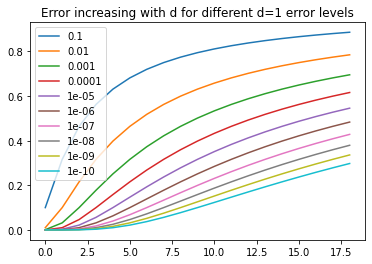

In [ ]:
for x in np.logspace(1,10,10):
  plt.plot(x**(-1/np.arange(1,20)), label=1/x)
plt.legend()
plt.title("Error increasing with d for different d=1 error levels");

<a name="cell-MCint-sampling-MCMC"></a>

## 11.1.0 Markov Chain Monte Carlo (MCMC) ([Return to TOC](#cell-TOC))

---

A ***Markov chain*** is a sequence of random variables whose sequential dependency structure satisfies the ***Markov property***

$$p_{X^{(t)}|X^{(t-1)}, \cdots, X^{(0)}}(x^{(t)} | x^{(t-1)}, \cdots, x^{(0)}) = p_{X^{(t)}|X^{(t-1)}}(x^{(t)} | x^{(t-1)})\require{cancel}$$

In a ***Markov chain*** $x^{(t)}$ and $x^{(t-2)}$ are not independent, but they are conditionally independent given $x^{(t-1)}$, i.e.,

$$\newcommand\ci{\perp\!\!\!\perp} x^{(t)} \cancel \ci  x^{(t-2)} \quad \text{ but } \quad  x^{(t)} \ci  x^{(t-2)} | x^{(t-1)}$$

and more generally

$$\newcommand\ci{\perp\!\!\!\perp} x^{(t)} \cancel \ci  x^{(t')} \quad \text{ but } \quad  x^{(t)} \ci  x^{(t')} | x^{(t^*)} \quad \text{ for } t < t^* < t'$$


Sequentially drawn samples using $p_{X^{(t)}|X^{(t-1)}}(x^{(t)} | x^{(t-1)})$ are samples from the joint distribution of $p_{X^{(T)}, \cdots, X^{(0)}}(x^{(T)}, \cdots, x^{(0)})$ since by the ***chain rule*** and the ***Markov property***

$$
\begin{align*}
p_{X^{(T)}, \cdots, X^{(0)}}(x^{(T)}, \cdots, x^{(0)}) = & {} \prod_{t=1}^T p_{X^{(t)}|X^{(t-1)}, \cdots, X^{(0)}}(x^{(t)} | x^{(t-1)}, \cdots, x^{(0)}) \\
= & {} \prod_{t=1}^T p_{X^{(t)}|X^{(t-1)}}(x^{(t)} | x^{(t-1)})
\end{align*}$$

This means that each $x^{(t)}$ must be a representative sample of its marginal distribution $p_{X^{(t)}}(x^{(t)})$ even though 

1. $x^{(t)}$ was instead sampled from $p_{X^{(t)}|X^{(t-1)}}(x^{(t)}|x^{(t-1)})$
2. resulting in the dependent collection of samples $(x^{(T)}, \cdots, x^{(0)})$

If the marginal distributions of each $x^{(t)}$ are identical so

$$x^{(t)} \sim p_{X^{(t)}}(x^{(t)}) = p_X(x^{(t)}) \text{ for all } t$$

then $(x^{(T)}, \cdots, x^{(0)})$ is a correlated sample from $p_X(x)$ where the dependence between $x^{(t)}$ and $x^{(t')}$ decays as $|t-t'|$ increases. A less correlated sample could be constructed using subsequences of $(x^{(T)}, \cdots, x^{(0)})$. But if $T$ is sufficiently large, the dependent sample must represent the distribution of $p_{X}$ well since all $x^{(t)}$ must be representative of the $p_X(x^{(t)})$.  This means that the bias from the dependence in the sample must eventually "wash out" and no longer matter in the context of all other samples together. 

***Markov chain Monte Carlo*** is when there are enough dependent samples $x^{(t)}$ from a ***Markov Chain*** that they can be used to sufficiently represent samples from $p_{X}$.  In this case, the dependent samples can be used for ***Markov Chain Monte Carlo integration***.

> Notice that while this characterizes each $x^{(t)}$ as a sample from $p_{X}$, the $x^{(t)}$ itself can be a multivariate random variable. 

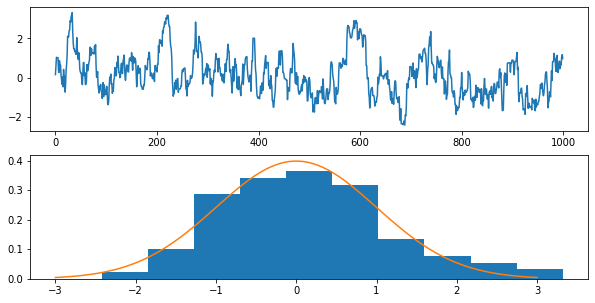

In [ ]:
# A demonstration of depdendent samples which
# over time nonetheless represent a marginal distribution
np.random.seed(410)
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1)
    dependent_samples = pm.sample(500, tune=False, return_inferencedata=False, 
                                  step=pm.Metropolis(vars=[x], S=np.array([0.5])))
fig,ax = plt.subplots(2,1, figsize=(10,5))
ax[0].plot(dependent_samples['x'])
ax[1].hist(dependent_samples['x'], density=True)
ax[1].plot(np.linspace(-3,3,100), stats.norm.pdf(np.linspace(-3,3,100)));

<a name="cell-MCint-SliceSampling"></a>

## 11.1.1 Slice Sampling ([Return to TOC](#cell-TOC))

---

***Slice sampling*** is an example of ***MCMC*** which produces a representative sample of a ***target distribution*** $p_X(x)$ of interest 
by carefully traversing a (dependent) sequential path "underneath" the density function of the ***target distribution***.

***Slice sampling*** is somewhat reminiscent of ***rejection sampling***, but ***slice sampling*** tries to not waste samples "outside" of the 2d sampling space.

***Slice sampling*** iteratively samples

- $y_t \sim \text{Unif}(0,p_X(x_{t-1}))$
- $x_t \sim \text{Unif}( \{x: y_{t} \leq p_X(x_t)\})$

where sampling $x_t$ can be done analytically (if applicable) or by
1. producing a bounding interval around $x_{t-1}$ 
2. uniformly sampling from the bounding interval

    a. rejecting the sample and adjusting the bounding interval if $p_X(x_t) < y_{t}$ and retuning to 2 

    b. keeping the sample if $y_{t} \leq p_X(x_t)$

|![](https://www.researchgate.net/profile/Michael-Jordan-3/publication/227276601/figure/fig14/AS:668556802928655@1536407771607/Slice-sampling-given-a-previous-sample-we-sample-a-uniform-variable-u-i-1-between-0.png)|
|-|
|https://www.researchgate.net/figure/Slice-sampling-given-a-previous-sample-we-sample-a-uniform-variable-u-i-1-between-0_fig14_227276601|
|![](https://www.researchgate.net/profile/Benyamin-Ghojogh/publication/345215567/figure/fig6/AS:953627036381186@1604373811408/The-steps-in-slice-sampling-algorithm.ppm)|
|https://www.researchgate.net/figure/The-steps-in-slice-sampling-algorithm_fig6_345215567|
|![](https://barumpark.com/assets/img/slicesamps-1.png)|
|https://barumpark.com/blog/2019/SliceSampling/|


<a name="cell-MCint-sampling-MCMC-gibbs"></a>

### 11.1.2 Gibbs Sampling ([Return to TOC](#cell-TOC))

---

***Gibbs sampling*** is the stochastic sampling analog of solving an optimization problem using ***Gauss-Seidel***. I.e., samples from $p(\theta_1, \cdots, \theta_q|x)$ may be generated by instead cyclically sampling from the full conditionals 

1. $p(\theta_1^{(t)}|\theta_q^{(t-1)}, \cdots, \theta_2^{(t-1)}, x)$
2. $p(\theta_2^{(t)}|\theta_q^{(t-1)}, \cdots, \theta_3^{(t-1)}, \theta_1^{(t)}, x)$
3. $p(\theta_3^{(t)}|\theta_q^{(t-1)}, \cdots, \theta_4^{(t-1)}, \theta_2^{(t)}, \theta_1^{(t)}, x)$
4. $p(\theta_4^{(t)}|\theta_q^{(t-1)}, \cdots, \theta_5^{(t-1)}, \theta_3^{(t)}, \theta_2^{(t)},\theta_1^{(t)}, x)$

   $\vdots$

$\quad$q. $p(\theta_q^{(t)}|\theta_{q-1}^{(t)}, \cdots, \theta_1^{(t)}, x)$, return to 1.

Since this process generates $\theta^{(t)}$ on the basis of $\theta^{(t-1)}$, it is a ***Markov process*** with respect to the parameter vector $\theta$.

While cyclical full conditional sampling of the ***Gibbs sampling strategy*** does not follow the ***chain rule*** for decomposing a joint distribution, it can nonetheless be shown that ***Gibbs sampling*** still forms a ***Markov chain*** of (dependent) samples from a 
***stationary distribution*** which converges to the desired ***target distribution*** $p(\theta_q, \cdots, \theta_1|x)$ of the parameters defining the full conditional distributions.

> ***Gibbs sampling*** was once a dominant staple of Bayesian model fitting methodology. However, the sequential dependence in the parameters induced by ***Gibbs sampling*** quickly suffers a prohibitive "curse of dimensionality" that limits its application to low dimentional parameter spaces. The advent of ***Hamiltonian Monte Carlo*** (***HMC***) which avoids inducing a sequential dependence in parameter sampling has thus relegated the use of ***Gibbs sampling*** to the domain of discrete random variable contexts (often in conjuction with ***Metropolis-Hastings***) where ***HMC*** (which only addresses continuous random variables) cannot be applied.

The canonical example of Gibbs sampling is for the normal-gamma posterior

$$\begin{align*}
p\left(x|\mu,\tau=\frac{1}{\sigma^2}\right) = {} & \prod_{i=1}^n \sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau}{2}(x_i-\mu)^2}\\
p(\mu,\tau) \propto {} & 1 \\
p(\mu,\tau| x) \propto p(\mu,\tau, x) \propto {} &  \tau^{n/2} e^{-\frac{\tau}{2} \sum_{i=1}^n (x_i-\mu)^2} \\
p(\tau|\mu, x) = {} & \text{Gamma}\left(\alpha = \frac{n}{2}+1, \beta= \frac{1}{2} \sum_{i=1}^n (x_i-\mu)^2 \right)\\
p(\mu| \tau, x)  \propto {} & e^{-\frac{\tau}{2} \sum_{i=1}^n \mu^2 - 2\mu x_i} =  e^{-\frac{\tau}{2} \left(n\mu^2 - 2\mu \sum_{i=1}^n x_i\right)} = e^{-\frac{\tau n }{2} \left(\mu^2 - 2\mu \bar x\right)}\\
  \propto {} & e^{-\frac{n \tau}{2} (\mu - \bar x)^2} \\
p(\mu| \sigma^2 = \tau^{-1}, x) = {} & N\left(E[\mu] = \bar x, Var(\mu) = \frac{\sigma^2}{n}\right)
\end{align*}$$

and see [here](https://bookdown.org/rdpeng/advstatcomp/gibbs-sampler.html) for the fully ***conjugate prior*** specification.

> This ***Gibbs sampler*** is demonstrated in the next section.

<a name="cell-MCint-sampling-MCMC-mixing"></a>

### 11.1.3 Convergence / Markov Chain Mixing ([Return to TOC](#cell-TOC))

---

Given a sequence of samples $\theta^{(t)}$ produced  from a ***Markov chain***, e.g., constructed with ***Gibbs sampling***, it is proper and best practice to  

1. assess the ***mixing*** of the ***Markov chain*** 
  > which can be suggestive of ***convergence*** of the ***Markov chain*** to the ***stationary target distribution*** but does not guarantee it
2. discard initial ***burn-in*** samples of the chain which suggest the ***Markov chain*** is still in a ***warm-up*** regime rather than a ***convergence*** regime

***Warm-up*** (i.e., ***burn-in***) and ***convergence*** and of a ***Markov chain*** can be assessed by examining the agreement (i.e., "convergence") of multiple chains with different initial values $\theta^{(0)}$.

1. Once a chain is judged (by agreement with differently initialized chains) to likely no longer be in a ***warm-up*** regime
2. the initial "***burn-in*** samples" of the chain are discared
3. then the chain is run for additional iterations until its respresentation is no longer meaningfully altered by further extension of the chain
4. and finally all ***Markov chains*** that have been trimmed of their ***burn-in*** samples are combined into a single chain which is assumed to be appropriately representative of the ***stationary distribution*** of the ***Markov chain*** and hence the ***target distribuion*** of interest.

> It is at this point that the bias in the representation caused by the dependency in the chain is "washed out" and the dependent sequence of samples itself is (presumably) a representative sample of the ***stationary distribution*** (regardless of its sequential dependency).
>
> > This is why ***Markov chain Monte Carlo integration*** based on sequentially dependent samples can be used as a form of ***Monte Carlo integration***.

In order to assess the agreement of different chaines, $M$ split chains of $N$ samples created from $M/2$ chains havled in the middle are used to calculate the [split-$\hat R$ metric](https://arxiv.org/abs/1903.08008) which compares interchain and intrachain variance as

$$\text{split-}\hat R = \sqrt{\frac{\frac{N-1}{N}W +  \overbrace{\frac{1}{M-1}\sum_{m=1}^M (\overline{\theta^{(m,\cdot)}} - \overline{\theta^{(\cdot,\cdot)}})^2}^{\text{between chain variance}} }{\underbrace{\frac{1}{M}\sum_{m=1}^M \frac{1}{N-1}\sum_{n=1}^N (\theta^{(m,n)} - \overline{\theta^{(m,\cdot)}})^2}_{\text{$W$: within chain variance}}} } $$

which yields a value of $1$ for indistinguishable chians, and which has split-$\hat R < 1.05$ as the recommended threshold for diagnosing a set of Markov chains as sufficiently similar.

In [ ]:
n = 30
x = stats.norm.rvs(size=n)
C = 2 # chains
G = 100 # Gibbs samples
mu,tau = np.zeros([C,G]),np.zeros([C,G])
# initialization
mu[:,0] = 1000
for c in range(C):
  for g in range(1,G):
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
    tau[c,g] = stats.gamma(a=n/2+1, scale=2/((x-mu[c,g-1])**2).sum()).rvs(size=1)
    mu[c,g] = stats.norm(x.mean(), scale=1/np.sqrt(tau[c,g]*n)).rvs(size=1)

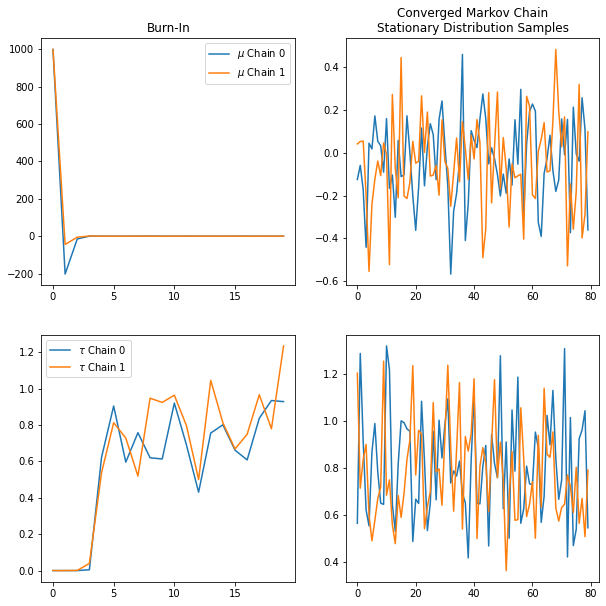

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].set_title("Burn-In")
ax[0,1].set_title("Converged Markov Chain\nStationary Distribution Samples")
burn = 20
for c in range(C):
  ax[0,0].plot(mu[c,:burn], label="$\\mu$ Chain "+str(c))
  ax[1,0].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
  ax[0,1].plot(mu[c,burn:])
  ax[1,1].plot(tau[c,burn:])

ax[0,0].legend()
_ = ax[1,0].legend()

In [ ]:
# Split-R-hat
# Split
chain = mu[:,burn:]#tau[:,burn:]
chain = chain.reshape(2*chain.shape[0], int(chain.shape[1]/2))
# R-hat
W = np.var(chain, ddof=1, axis=1).mean()
B = ((np.mean(chain, axis=1) - chain.mean())**2).sum()/(chain.shape[0]-1)
print("R-hat: ", np.sqrt((chain.shape[1]-1)/(chain.shape[1]-burn) + B/W))
# We should collect more samples... This is not yet suggestive of convergence

R-hat:  1.4005582362860476


<a name="cell-MCint-sampling-MCMC-MH"></a>

### 11.1.4 Metropolis-Hastings (MH) ([Return to TOC](#cell-TOC))

---

The (***Markov***) ***proposal distribution*** 

$$\tilde \theta^{(t)} \sim \tilde p(\tilde \theta^{(t)}|\theta^{(t-1)})$$

accepted as  

$$\theta^{(t)} = \left\{\begin{array}{ll}
\tilde \theta^{(t)} & \text{with probability } \min\left(1,\frac{p(\tilde \theta^{(t)}|x)}{p(\theta^{(t-1)}|x)}\frac{\tilde p(\theta^{(t-1)}|\tilde \theta^{(t)})}{\tilde p(\tilde \theta^{(t)}|\theta^{(t-1)})}\right)\\
\theta^{(t-1)} & \text{otherwise}
\end{array}\right.$$

will create a ***Markov chain*** with ***stationary distribution*** $p(\theta|x)$. 

> This was demonstrated above as the first example in [Markov Chain Monte Carlo]() section.

Further, for ***symmetric proposal distribution***  

$$\frac{\tilde p(\theta^{(t-1)}|\tilde \theta^{(t)})}{\tilde p(\tilde \theta^{(t)}|\theta^{(t-1)})} = 1$$

the ***acceptance probability*** reduces to

$$\min\left(1,\frac{p(\tilde \theta^{(t)}|x)}{p(\theta^{(t-1)}|x)}\right)$$

The ***acceptance probability*** is particularly important because if proposals are not accepted at a high frequency, then the ***MH Markov chain*** will not explore the distributional space efficiently (since it does not move from it's current value each time a proposal is rejected).  ***Markov chains*** which are prone to frequently getting stuck and not moving for several iterations are called ***sticky MCMC chains***.  Such trajectories are also said to have ***poor mixing***. 

> ***MCMC*** based on ***Gibbs sampling*** can have ***poor***/***slow mixing*** since only a single coordinate is updated at a time (conditional on the current value of the others). Such ***MCMC chains*** would not be called ***sticky***, however, because they do not literally get "stuck" at a single value while continuing to reject proposed updates as can happen with ***MH MCMC chains***. 

In [13]:
# Here's an example of MH with a non-symmetric proposal
proposal_dist = stats.gamma(a=2, loc=-2)
target_dist = stats.norm()
T = 1000
MH_samples = np.zeros(T)
for t in range(1,T):
  current = MH_samples[t-1]
  proposal = current + proposal_dist.rvs(size=1)
  acceptance_probability = target_dist.pdf(proposal)/target_dist.pdf(current)*\
                           proposal_dist.pdf(current-proposal)/proposal_dist.pdf(proposal-current)
  if stats.uniform().rvs(size=1) < acceptance_probability:
    MH_samples[t] = proposal
  else:
    MH_samples[t] = MH_samples[t-1]

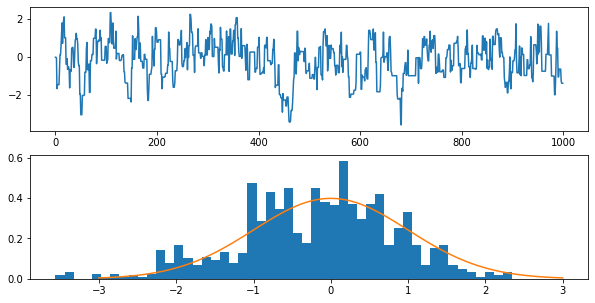

In [14]:
fig,ax = plt.subplots(2,1, figsize=(10,5))
ax[0].plot(MH_samples)
ax[1].hist(MH_samples, density=True, bins=50)
x = np.linspace(-3,3,100)
ax[1].plot(x, target_dist.pdf(x))

<a name="cell-MCint-sampling-MCMC-transitionK"></a>

### [OMITTED] Transition Kernels ([Return to TOC](#cell-TOC))

---

Suppose the ***target distribution*** is Bernoulli with $p=2/3$, and the ***proposal distribution*** is Bernoulli  with $p=1/2$. The ***transition matrix*** is then 

\begin{align*}  {} &  \left[ \begin{array}{cc} \Pr(\theta^{(t)}=0| \theta^{(t-1)}=0 ) & \Pr(\theta^{(t)}=1| \theta^{(t-1)}=0 )\\  \Pr(\theta^{(t)}=0| \theta^{(t-1)}=1 ) & \Pr(\theta^{(t)}=1| \theta^{(t-1)}=1 )  \end{array}\right]\\
{} =  {} & \, \left[ \begin{array}{ll} \Pr(\tilde \theta^{(t)}=0) \times \frac{p(\tilde \theta^{(t)}=0|x)}{p(\theta^{(t-1)}=0|x)} & \Pr(\tilde \theta^{(t)}=1) \times  \frac{p(\tilde \theta^{(t)}=1|x)}{p(\theta^{(t-1)}=0|x)}\\  \Pr(\tilde \theta^{(t)}=0) \times \frac{p(\tilde \theta^{(t)}=0|x)}{p(\theta^{(t-1)}=1|x)} & \Pr(\tilde \theta^{(t)}=1) \times  \frac{p(\tilde \theta^{(t)}=1|x)}{p(\theta^{(t-1)}=1|x)} + \Pr(\tilde \theta^{(t)}=0) \times  \frac{p(\tilde \theta^{(t)}=0|x)}{p(\theta^{(t-1)}=1|x)}  \end{array}\right]\\
{} = & \left[ \begin{array}{ll} \frac{1}{2} \times 1 = \frac{1}{2} & \frac{1}{2} \times \min(1,\frac{2/3}{1/3}) = \frac{1}{2} \\  \frac{1}{2} \times \frac{1/3}{2/3} = \frac{1}{4} & \frac{1}{2} \times  1 + \frac{1}{2} \times (1- \frac{1/3}{2/3}) = \frac{3}{4} \end{array}\right]
\end{align*}
where the bottom right element of the matrix is the only situation where either proposal could lead to the desired transition since $\frac{p(\tilde \theta^{(t)}=1|x)}{p(\theta^{(t-1)}=0|x)} > 1$ means $\tilde \theta^{(t)}=1$ is always accepted when $\theta^{(t-1)}=0$. 

Raising the transition matrix to the $T^{th}$ power will result in any initial value of $\theta^{(0)}$ (i.e., any pointmass probability distribution $\delta_{\theta^{(0)}}$) into the desired Bernoulli target distribution. 

$$\underset{\begin{array}{c}\theta^{(0)}\;\; =\end{array}}{\begin{array}{c}\;\end{array}} \underset{\begin{array}{cc}0 & 1\end{array}}{\overbrace{\left[\begin{array}{cc}1&0\end{array}\right]}^{\text{initialization}}} 
\left[ \begin{array}{cc} \Pr(\theta^{(t)}=0| \theta^{(t-1)}=0 ) & \Pr(\theta^{(t)}=1| \theta^{(t-1)}=0 )\\  \Pr(\theta^{(t)}=0| \theta^{(t-1)}=1 ) & \Pr(\theta^{(t)}=1| \theta^{(t-1)}=1 )  \end{array}\right]^T 
\approx  \underset{\begin{array}{cc}0\; &\; \; 1\end{array}}{\left[\begin{array}{cc}1/3&2/3\end{array}\right]} \underset{\begin{array}{c}= \;\; \theta^{(t)}\end{array}}{\begin{array}{c}\;\end{array}}
$$

Another way to see this is to notice that for large enough $T$

$$\left[\begin{array}{cc}0.5 & 0.5\\0.25&0.75\end{array}\right]^t \approx \left[\begin{array}{cc}1/3& 2/3\\1/3&2/3\end{array}\right]$$

so all the rows of the exponentiated matrix will be the ***stationary distribution*** of the matrix, and thus any initialization row vector summing to 1 and left multiplied by this matrix must be the ***stationary distribution*** of the matrix.

In [15]:
A = np.array([[.5,.5],[.25,.75]]) 
np.array([1/3,2/3]).dot(A)

array([0.33333333, 0.66666667])

In [ ]:
# intialize A and then multiply it by itself several times
#A = np.array([[.5,.5],[.25,.75]]) # np.array([1/3,2/3]).dot(A)
A = A.dot(A) # A**t will not work as it is element-wise
A

<a name="cell-MCint-sampling-MCMC-db"></a>

### [OMITTED] Detailed Balance ([Return to TOC](#cell-TOC))

---
Some technical remarks that can be understoood in the context of the above example are as follows.
- The ***sationary distribution*** $\boldsymbol\pi_K$ of a ***Markov transition kernel*** $K$ is ***invariant*** under ***transition*** so that $\boldsymbol\pi_K = K(\boldsymbol\pi_K)$.
- The distribution of a ***converged Markov process*** is ***independent of starting state*** and is equal to the ***stationary distribution*** so that $K^T(\boldsymbol\pi^0) = \boldsymbol\pi_K$ for large enough $T$ regardless of the choice of $\boldsymbol\pi^0$.
- A ***Markov process*** will ***converge*** if it is ***ergodic*** which means it is 
  - ***irredicible*** so all states may be reached from all states
  - ***aperiodic*** so it is not deterministically cyclic

  and a sufficient (but not necessary) condition for this is ***detailed balance*** which requires that the process is 
  - ***reversible*** so $\tilde p(\boldsymbol\pi^{(t)}|\boldsymbol\pi^{(t-1)})p(\boldsymbol\pi^{(t-1)}|x) = \tilde p(\boldsymbol\pi^{(t-1)}|\boldsymbol\pi^{(t)})p(\boldsymbol\pi^{(t)}|x)$

> ***Metropolis-Hastings*** satisfies ***detailed balance*** and thus guarantees ***ergodicity***, and hence ***convergence***, since
> 
> $$\begin{align*}
\frac{p(\boldsymbol\pi^{(t)}|x)}{p(\boldsymbol\pi^{(t-1)}|x)} = \frac{\min\left(1, \frac{p(\boldsymbol\pi^{(t)}|x)}{p(\boldsymbol\pi^{(t-1)}|x)} \frac{\tilde p(\boldsymbol\pi^{(t-1)}|\boldsymbol\pi^{(t)})}{\tilde p(\boldsymbol\pi^{(t)}|\boldsymbol\pi^{(t-1)})}\right)}{\min\left(1, \frac{p(\boldsymbol\pi^{(t-1)}|x)}{p(\boldsymbol\pi^{(t)}|x)}\frac{\tilde p(\boldsymbol\pi^{(t)}|\boldsymbol\pi^{(t-1)})}{\tilde p(\boldsymbol\pi^{(t-1)}|\boldsymbol\pi^{(t)})}\right) } \frac{\tilde p(\boldsymbol\pi^{(t)}|\boldsymbol\pi^{(t-1)})}{\tilde p(\boldsymbol\pi^{(t-1)}|\boldsymbol\pi^{(t)})} = {} & \frac{\tilde p(\boldsymbol\pi^{(t)}|\boldsymbol\pi^{(t-1)})}{\tilde p(\boldsymbol\pi^{(t-1)}|\boldsymbol\pi^{(t)})}
\end{align*}$$
> 
> because either
> - the $\min$ function will evaluate to $1$ in the numerator (or the denomenator) since these terms are reciprocal, so the proposal ratio will cancel and the density ratios will be equal
>
> or 
> - both the numerator and the denomenator evaluate to $1$, which immediately satisfies ***detailed balance***.

In [16]:
# Acceptance Rate
(MH_samples[:-1]!=MH_samples[1:]).sum()/(T-1)
# Hmm... kinda wasteful...

0.5155155155155156

<a name="cell-MCint-sampling-MCMC-HMC"></a>

## 11.2 Hamiltonian Dynamics ([Return to TOC](#cell-TOC))

---

A ***Hamiltonian system*** is ***physical dynamics system*** which decomposes 
***energy*** into ***potential*** $U(\theta)$ and ***kinetic*** $K(v)$ ***energy*** according to the ***Hamiltonian energy equation*** which obeys the ***law of conservation of energy***

$$\Large
\begin{align*}
H(\theta, z) = {} & U(\theta) + K(v|\theta) \\
\text{often simplified to } \Longrightarrow \quad = {} & U(\theta) + K(v)
\end{align*}$$

From a statistical modeling perspective, the ***Hamiltonian energy equation*** is viewed as the log of the joint probability distribution of some parameters of interest $\theta$ and  some ***auxilliary variables*** $v$ (of the same dimension as $\theta$).  The ***auxilliary variables*** $v$ are not actually of intereset and are only introduced for the purpose of defining the ***Hamiltonian system***.

The ***potential energy*** $U(\theta)$ and ***kinetic*** $K(v)$ ***energy*** (often referred to as ***momentum*** or ***velocity***) are then perfectly inversely tied together, and always compensate for one another so long as the system is always evolved according to the differential equations 

$$\Large \begin{align*} 
\frac{d\theta}{dt} & = {} \frac{dH}{dv}(v(t)) & \frac{dv}{dt} & = {}  -\frac{dH}{d\theta}(\theta(t))\\
\end{align*}$$

This means that as the $\theta$ and $v$ parameters of the system evolve across time $t$, the overall ***energy*** (i.e., log-likelihood) remains constant.

> The $\theta$ and $v$ parameters evolution through time can be discretely modeled using small time steps and the corresponding changes in time $\frac{d\theta}{dt}$ and $\frac{dv}{dt}$ defined through the partial derivatives of the overall ***energy*** function $H$ given above and as demonstrated in the [Week 1 course notes]().

This process results in new (temporally evolved) parameters values $\theta_0 \overset{time}{\rightarrow} \theta_t$ and $v_0 \overset{time}{\rightarrow} v_t$ such that $p(\theta_0, v_0|x) = p(\theta_t, v_t|x)$ which means that evolving parameter values with ***Hamiltonian mechanics*** moves parameters along the ***level-set contours*** of the ***joint (log) probability distribution***. This allows efficient exploration of the distribution. 

> Note that the appearance of the $p(\theta_t, v_t|x)$ notation suggests that the joint density of the $(\theta, v)$ is a ***posterior distribution*** of interest.  Indeed this is true, but, since $v$ is just an ***auxiliary variable***, it's most common to just use the simplifying assumption $p(\theta_t, v_t|x) = p(\theta_t|x)p(v_t)$ as part of the overall specification so that the ***Hamiltonian system*** is actually $H(\theta, z|x) = U(\theta|x) + K(v)$.

<a name="cell-MCint-sampling-MCMC-HMC2"></a>

## 11.2.0 Hamiltonian Dynamics and Metropolis-Hastings ([Return to TOC](#cell-TOC))

---

The evolution $\theta_0 \overset{time}{\rightarrow} \theta_t$ and $v_0 \overset{time}{\rightarrow} v_t$ according to ***Hamiltonian dynamics*** is (theoretically) deterministic.  So moving along the contours of a probability distribution certaintly does not constitute random sampling.  A first step to address this issue would be to sample $(\theta_t, v_t)$ ***uniformly*** from all possible points on the current contour of the distribution. But since this countour is not generally known in advance, a way to randomly sample from this contour set would be to randomly choose the number of steps $t$ taken to evolve the system.  That is, choose a random trajectory length along the contour.  This would make $(\theta_t, v_t)$ a proposal that depends on $(\theta_0, v_0)$ and a random choice for $t$. 

This strategy would only randomly move around the contours, however.  So some further perturbation off of the contour (up to a higher contour level or a lower contour level) is needed to fully explore the distribution. This could be done by randomly perturbing the final ***momentum*** $v_t$ to $v_t+\epsilon$ which would change the overall ***energy*** level since this change would not follow the ***Hamiltonian dynamics*** guaranteeing the ***law of convervation of energy***.


|These concepts can be seen in "FIG. 22" of a [stack exchange question](https://stats.stackexchange.com/questions/324346/hamiltonian-monte-carlo-how-to-make-sense-of-the-metropolis-hasting-proposal) referencing an [introductory HMC paper](https://arxiv.org/abs/1701.02434) where $p=\theta$ *potential energy* and $q=v$ *momentum*|
|:-:|
|![](https://i.stack.imgur.com/mJoHA.png)|
|A fun HMC visualization worth looking over is given in this [Brilliantly Wrong blog post](https://arogozhnikov.github.io/2016/12/19/markov_chain_monte_carlo.html); however, trajectory length not animation speed reflects total ***energy***.|
|The Z-axis is the ***potential energy*** $U(\theta)$ which is inversely proportional to the ***kinetic energy*** $K(v)$ with the ***momentum*** $v$ implicit based on the hill climbing.|
|Including $v$ into this visualization would require 4 parameter dimensions, and would traverse contour levels on a 5th dimension in the manner of "FIG. 22".|
|Since $\theta$ and $v$ are two-dimensional, trajectories are not just forwards or backwards, but can be given initial directions and evolved in two-dimensional space.|

The above discussion indicates that ***Hamiltonian dynamics*** along with random trajectory lengths $t$ and a final perturbation $\epsilon$ allows the creation of the proposal $(\theta_t, v_t+\epsilon_t)$ from the initial value $(\theta_0, v_0)$. ***Metropolis-Hastings*** can thus be used to determine if this proposal should be accepted or rejected according to the probability

$$\min\left(1,\frac{p(\theta_t, v_t+\epsilon|x)}{p(\theta_0, v_0|x)}\frac{\tilde p(\theta_0, v_0|\theta_t, v_t+\epsilon)}{\tilde p(\theta_t, v_t+\epsilon|\theta_0, v_0)}\right)$$

where $\tilde p(\theta_t, v_t+\epsilon|\theta_0, v_0)$ indicates the probability of evolving $\theta_0, v_0$ to $\theta_t, v_t+\epsilon$ which has to do with the random proposal distributions for $t$ and $\epsilon$. 

> It's worth noting that due to numerical error in the discrete time approximation of the evolution of the ***Hamiltonian dynamics system*** we generally only have
>
> $$p(\theta_0, v_0|x) \approx p(\theta_t, v_t|x) \quad \text{ rather than } \quad p(\theta_0, v_0|x) = p(\theta_t, v_t|x)$$ 
>
> This, however, can just be viewed as additional noise that is just part of the $p(\theta_t, v_t+\epsilon|\theta_0, v_0)$ proposal process whose probabilities still only depend on the random proposal distributions for $t$ and $\epsilon$. Nonetheless, drifting too far away from the contour could result in a poor proposal if it drifts too far away from high ***energy*** values so that $p(\theta_t, v_t+\epsilon|x) << p(\theta_0, v_0|x)$ which means there will be a very low ***Metropolis-Hastings*** acceptance probability and would produce a ***sticky MH MCMC chain***. Thus, it is important to stay close to the the true ***energy*** contour. 
>
> This is why ***symplectic integrators*** such as the ***leap-frog integrator*** are very useful. They allow the ***Hamiltonian dynamics system*** to be evolved over time with minimal drift away from the intended ***energy*** contour based on the initial $(\theta_0, v_0)$ value.

Ideally, proposals taken from the parameter trajectories $\theta_0 \overset{time}{\rightarrow} \theta_t$ and $v_0 \overset{time}{\rightarrow} v_t+\epsilon$ would tend to be accepted with high probability to avoid a ***sticky MH MCMC chain*** and efficiently explore the sample space of the distribution.  But there is a tradeoff here.

- Longer trajectories along ***energy contours*** will tend to provide better exploration of the distribution; but, the longer a trajectory is run, the more numerical error can be expected so the less it actually approximates the trajectory of interest.  Thus, an evolved trajectory may not reasonably be able to travel too far from from its starting value and still maintaining a reasonably high ***energy*** level.  This is the case for even the best ***symplectic integrators*** such as the ***leap-frog integrator***. 

  > ***Symplectic integrators*** such as the ***leapfrog integrator*** are thus indispensable in the ***HMC*** context for reducing numerical error in ***Hamiltonian system evolution*** in order to create longer trajectories. The role of the ***leapfrog integrator*** in the full ***HMC*** workflow is nicely described in the ***Stan HMC software*** [reference manual](https://mc-stan.org/docs/2_19/reference-manual/hamiltonian-monte-carlo.html).


<a name="cell-MCint-sampling-MCMC-HMC3"></a>

## 11.2.1 Marginal Samples from Joint Distributions ([Return to TOC](#cell-TOC))

---

A ***HMC chain*** created with ***MH MCMC*** based on perturbations of propsoals created through ***Hamiltonian dynamics***

$$(\theta^{(T)}, v^{(T)}), \cdots, (\theta^{(1)}, v^{(1)}), (\theta^{(0)}, v^{(0)})$$

represents a sequence of dependent samples from the target joint distribution $(\theta^{(t)}, v^{(t)}) \sim p(\theta, v|x)$.  

Therefore, 

$$\theta^{(T)}, \cdots, \theta^{(1)}, \theta^{(0)}$$

represents a sequence of dependent samples from the target marginal distribution $\theta^{(t)} \sim p(\theta| x)$.  






<a name="cell-MCint-sampling-MCMC-diagnostics"></a>

## 11.2.2 Diagnostics ([Return to TOC](#cell-TOC))

---

In ***HMC*** the assessment of ***mixing*** is still diagnosed with split-$\hat R \leq 1.05$ suggestive of convergence of the ***Markov chain*** to its ***stationary distribution***. 

However, an additional characteristic of ***HMC*** is that its algorithmic performance can be inferred from its runtime behavior.

1. **energy countour trajectory step sizes**
  
   When discretely approximating parameter trajectories along ***energy contours*** of a probability distribution with step size $\delta$, the $p(\theta_t,v_t|x)$ should remain constant. Numerical instability such that $p(\theta_{t+\delta},v_{t+\delta}|x) \not \approx p(\theta_t,v_t|x)$ means the algorithm is failing.  This is caused by curvature in the ***energy*** function that is so excessive that $t+\delta$ discrete approximation of the ***Hamiltonian dynamics system*** is not small enough to follow the intended ***energy contours***. This creates a ***divergence*** in the ***energy*** which can be detected. Correspondingly adaptively shortening the step sizes length reduces ***divergences*** but also slows down the absolute progress of the trajectory away from its staring value.  Thus, any increasing computational cost of moving away from starting values under these (generally default) adaptive procedures is ***diagnostic*** of ***extreme distributional curvature***.

  - ***HMC*** sampling from distributions with ***extreme curvatures*** does not work well because it is computationally expensive to move away away from a position of ***high curvature*** while still maintaing the same energy level along the exiting trajectory; thus, the ***HMC chain*** created through ***high curvature regions*** is simultaneously computationally expensive while at the same time being unable to make progress away from previous samples in the ***HMC chain***. ***HMC chains*** in such regions are hence highly dependent, and thus of little informative value even with high sample counts, all while being extremely computationally expensive to obtain.

  - Models that entail regions of high curvature are untractable and must be avoided because ***HMC*** sampling of such models inevitably leads to misestimation and hence misuse. Reparameterizations or different probability model specifications that induce smoother distributions must be used instead of distributions causing computationally pathological sampling. 
  
2. **Metropolis-Hastings accepatance rates versus dependence in HMC chains**

   A ***HMC*** algorithm should achieve a decent ***Metropolis-Hastings proposal accepatance rate*** while producing samples that are not too highly correlated.  ***Metropolis-Hastings proposals*** that are too frequently rejected will produced a very ***sticky*** chain that will not efficiently explore the space of the distribution. ***HMC chains*** that are highly correlated are not providing efficient movement across the parameter space, and thus do not doing a good job of exploring the space of the distribution. A ***HMC*** scheme that achieves both a high ***Metropolis-Hastings proposal accepatance rate*** as well as produces ***HMS chains*** that are not too highly dependent can be extremely computationally efficient in exploring the space of the ***target stationary distribution***. On the other hand, ***HMC*** algorithmic performance that cannot quickly traverse (i.e., sample) the ***typical set*** of its ***target distribution*** while maintaing a desirable ***acceptance rate*** may be computationally intractible. 

  - Reducing trajectory lengths of discrete approximations to ***Hamiltonian dynamics*** used to generate parameter proposals and dampening the $\epsilon$ perturbations on the ***momentum proposals*** helps keep $p(\theta_t, v_t+\epsilon|x) \approx p(\theta_0, v_0|x)$ so that acceptance probabilities remain high; however, the ability to move $\theta_t$ far away from $\theta_0$ and fluidly transition between different ***energy contours*** of a probability distribution helps to decay the ***Markov dependence*** in ***HMC*** chains so that samples are less dependent and hence more efficiently explore the space of the probability distribution. 
  - ***Automatic tuning*** of ***acceptance rates*** for ***Metropolis-Hastings proposal steps*** are standard components of ***HMC*** algorithms.  Typically, an initially highly deviating proposal distribution will be increasingly muted until a target acceptance rate, e.g., $80\%$ is reached.  At that point it is hoped that the proposals are still typically far away from the previous samples so that dependency within the ***HMC chain*** is not too strong. Failure to achieve sufficiently large deviations is the result of numerically unstable ***Hamiltonian trajectory evolutions*** that must be shorted or overly volatile ***momentum*** perturbations that must be dampened.

3. **Effective samples sizes using split-$\hat R$**

  ***Effective sample size***

  $$n_{\text{eff}} = \frac{n}{\sum_{t=-\infty}^\infty\rho_t} = \frac{n}{1+2\sum_{t=1}^\infty\rho_t} \quad \text{ for order $t$ autocorrelations } \quad \rho_t $$

  can be estimated in ***Markov chain*** contexts with multiple ***chains***  based on [similar calculations](https://arxiv.org/abs/1903.08008) to those used for computing split-$\hat R$. Since $n_{\text{eff}}$ increases as the ***autocorrelations*** $\rho_t$ decrease, increasing $n_{\text{eff}}$ corresponds exactly to increasing ***MH proposal acceptance rates*** while reducing the the dependency in ***HMC chains***.  Thus, $n_{\text{eff}}$ gives a very simple way to evaluate the effectiveness of the balance between ***acceptance rates*** and ***HMC chain*** dependence. 

  - To reduce the depedence in ***HMC chains***, the ***energy contour*** trajectories could be extended. However, this would require additional computation, and it might actually be more computation efficient to just collect more ***HMC*** samples at the current $n_{\text{eff}}$ rates.     
  

In [2]:
# This is a classic example of a hierarchical "random effects" Bayesian model 
# The probabilistic specification and the code below can be found here:
# https://docs.pymc.io/en/v3/pymc-examples/examples/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html
# https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html#diagnosing-with-divergences

import logging
_log = logging.getLogger("pymc")
_log.setLevel(logging.INFO) # Option 0
#_log.setLevel(logging.WARNING) # Option 1
#_log.setLevel(logging.ERROR) # Option 2

# Suppose there are 8 groups with average measurements y and standard error sigma
# where the standard errors have to do with sample size and intergroup variaion
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
# Suppose we are interested in learning the overall average across all 8 groups
# accounting for the uncertainty in each of the measurements of the groups
# using the following probabilisitic programming specification
with pm.Model() as Centered_eight:
    # we assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5) 
    # and we assume the following probabilistic hierarchy
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J)
    # Note that if tau was small, then the density evalution above 
    # could change rapidly for changes in theta
    # This means that the energy has high curvature 
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

# This model can be sampled using HMC
# The auxiliary variables are added to the specification "under the hood"
SEED = [20100420, 20134234] # random seeds for each of two run HMC chains
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True}) 

INFO:pymc:Auto-assigning NUTS sampler...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Sequential sampling (2 chains in 1 job)
INFO:pymc:NUTS: [mu, tau, theta]


INFO:pymc:Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 43 seconds.
INFO:pymc:We recommend running at least 4 chains for robust computation of convergence diagnostics


In [3]:
# previous versions of pymc, i.e., pymc3 gave the following errors

#ERROR:pymc3:There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
#WARNING:pymc3:The acceptance probability does not match the target. It is 0.7073435948155605, but should be close to 0.8. Try to increase the number of tuning steps.
#ERROR:pymc3:There were 265 divergences after tuning. Increase `target_accept` or reparameterize.
#WARNING:pymc3:The acceptance probability does not match the target. It is 0.6771097025238918, but should be close to 0.8. Try to increase the number of tuning steps.
#ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.

# but the most recent versions of pymc no longer track this, so
# `_log.setLevel(logging.WARNING)` and `_log.setLevel(logging.ERROR)`
# have no effect now

In [4]:
# As is seen above, there are many divergences; and, the acceptance rate is quite low
# This is because the specification above induces high curature in the energy 
# as described above; but, here's a specification that alleviates this problem.

with pm.Model() as NonCentered_eight:
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau
    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations below
    # so the energy still has high curvature with respect to tau; but, 
    # it no longer has high curvature with respect to theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED, 
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True}) 
# The suggestion to "Increase `target_accept`" below means use smaller
# \delta time steps when evolving the Hamiltonian dynamics:
# this would result in fewer divergences and higher acceptances rates

INFO:pymc:Auto-assigning NUTS sampler...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Sequential sampling (2 chains in 1 job)
INFO:pymc:NUTS: [mu, tau, theta_t]


INFO:pymc:Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 20 seconds.
INFO:pymc:We recommend running at least 4 chains for robust computation of convergence diagnostics


In [17]:
# These warnings are no longer tracked
# ERROR:pymc3:There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
# ERROR:pymc3:There were 40 divergences after tuning. Increase `target_accept` or reparameterize.

In [19]:
# Current support for examining sampling diagnostics is given here
# https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/sampler-stats.html
# Demonstrations of posterior analysis is demonstrated here 
# https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#posterior-analysis
# and will be explored during your final homework assignment

Centered Parameterization:
- divergences require decreased step size and hence increasing HMC chain dependency
- and hence decreased effective sample size
Uncentered Parameterization:
- less divergences alows longer contour trajectories step size and hence increasing HMC chain dependency
- and hence decreased effective sample size


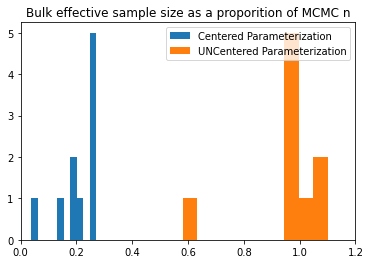

In [9]:
print('Centered Parameterization:')
print('- divergences require decreased step size and hence increasing HMC chain dependency')
print('- and hence decreased effective sample size')
with Centered_eight: 
  plt.hist(pm.summary(fit_C)['ess_bulk']/10000,
           label = "Centered Parameterization")
print('Uncentered Parameterization:')
print('- less divergences alows longer contour trajectories step size and hence increasing HMC chain dependency')
print('- and hence decreased effective sample size')
with NonCentered_eight: 
  plt.hist(pm.summary(fit_NC)['ess_bulk'][9:]/10000,
           label = "UNCentered Parameterization")
plt.legend(); plt.title("Bulk effective sample size as a proporition of MCMC n"); plt.xlim((0,1.2));

In [6]:
# Above are histograms of the effective sample size 
# as a fraction of of the number of HMC samples
# for each of the parameters in the model
with Centered_eight: 
  print(pm.summary(fit_C)['ess_bulk'])

mu          1534.0
theta[0]    1858.0
theta[1]    2541.0
theta[2]    2645.0
theta[3]    2686.0
theta[4]    2197.0
theta[5]    2558.0
theta[6]    1944.0
theta[7]    2705.0
tau          381.0
Name: ess_bulk, dtype: float64


In [7]:
# the noncentered parameterization keeps track of theta_t on the N(0,1) scale
# but the deterministically transformed theta is really the parameter that matters
with NonCentered_eight: 
  print(pm.summary(fit_NC)['ess_bulk'])

mu             9312.0
theta_t[0]    10129.0
theta_t[1]     9280.0
theta_t[2]    11847.0
theta_t[3]     9086.0
theta_t[4]     7475.0
theta_t[5]     8972.0
theta_t[6]     7980.0
theta_t[7]     8229.0
tau            5819.0
theta[0]       9928.0
theta[1]      11003.0
theta[2]       9448.0
theta[3]      10218.0
theta[4]       9752.0
theta[5]      10726.0
theta[6]       9559.0
theta[7]       9480.0
Name: ess_bulk, dtype: float64


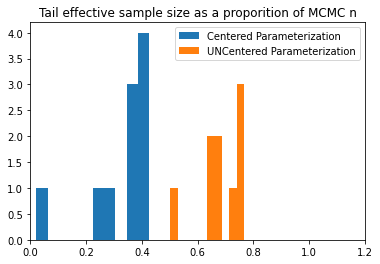

In [8]:
# Here is another interesting diagnostic which shows the effective sample size
# when restricted to samples in the tails of the HMC samples.
# It suggests how efficiently the HMC samples traverse the extremes of the distribution
with Centered_eight: 
  plt.hist(pm.summary(fit_C)['ess_tail']/10000,
           label = "Centered Parameterization")
with NonCentered_eight: 
  plt.hist(pm.summary(fit_NC)['ess_tail'][9:]/10000,
           label = "UNCentered Parameterization")
plt.legend(); plt.title("Tail effective sample size as a proporition of MCMC n"); plt.xlim((0,1.2));